**For a streamlined EDA process amongst 3 teammates, we have subdivided this notebook into 3 sections, with each's own work contained within their dedicated section.**

</div>

> !NOTE
> Documentation on individual sections can be found attached to this folder.

In [31]:
# Imports
import pandas as pd
import numpy as np
import sqlite3
import dataprep
from dataprep.eda import create_report
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

***

# **Thierno**

In [3]:
path = '/Users/Marcy_Student/Desktop/CID_data-slayer-corps/sql/CID_database_clean.db'
conn = sqlite3.connect(path)
cursor = conn.cursor()

# Loading tables and initial exploration

In [4]:
# Get all table names
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(tables_query, conn)
print("Available tables in database:")
print(tables)
print(f"\nTotal tables: {len(tables)}")

table = ['dim_environment', 'dim_location', 'dim_demographic','fact_school_outcomes']

results = {}
for t in table:
    query = f'SELECT * FROM {t}'
    results[t] = pd.read_sql_query(query, conn)

dim_environment = results['dim_environment']
dim_location = results['dim_location']
dim_demographic = results['dim_demographic']
fact_school_outcomes = results['fact_school_outcomes']

#create_report(dim_demographic)
#create_report(dim_environment)
#create_report(fact_school_outcomes)
#create_report(dim_location)

Available tables in database:
                   name
0       dim_environment
1          dim_location
2       dim_demographic
3  fact_school_outcomes
4       sqlite_sequence

Total tables: 5


In [5]:
# Print all column names to find the correct one
print(dim_environment.columns.tolist())

['DBN', 'school_name', 'enrollment', 'instruction_performance_rating', 'teaching_environment_pct_positive', 'family_involvement_pct_positive', 'advising_planning_pct_positive', 'economic_need_index', 'percent_temp_housing', 'percent_hra_eligible', 'avg_student_attendance', 'n_count_postsecondary_enrollment_6_months', 'readiness_gap_hs', 'metric_value_4yr_ccr_all_students', 'n_count_4yr_graduation_rate_all_students', 'metric_value_4yr_graduation_rate_all_students', 'metric_value_4yr_hs_persistence', 'n_count_4yr_hs_persistence', 'metric_value_postsecondary_enrollment_6_months']


### ANALYZING ENI

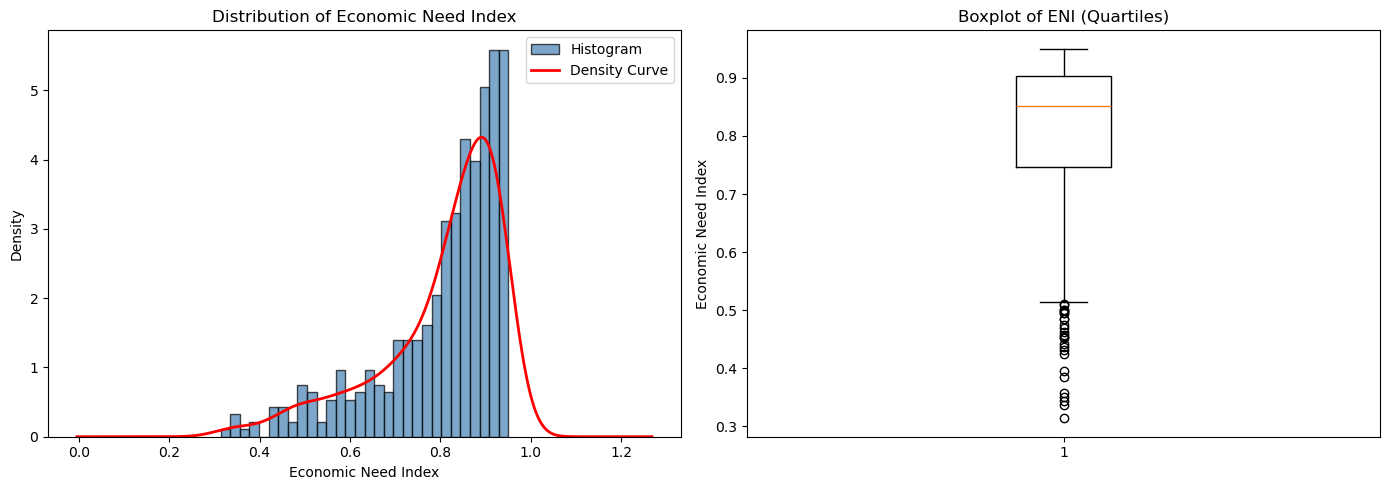

/var/folders/bs/gtwb0lj97nb4v95968dmfzww0000gp/T/ipykernel_58898/3877437137.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=env_loc, x='borough', y='economic_need_index', order=borough_order, palette='viridis')


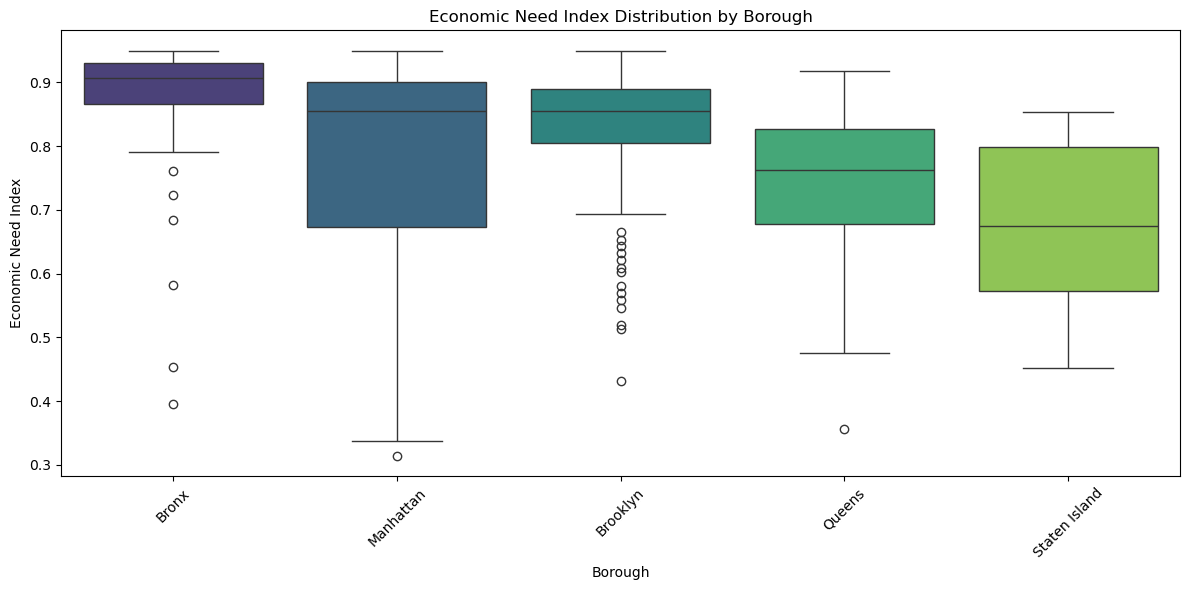

ENI STATISTICS BY BOROUGH
                 mean  median     std  count
borough                                     
Bronx          0.8818  0.9075  0.0887    100
Manhattan      0.7701  0.8550  0.1733    111
Brooklyn       0.8254  0.8545  0.1040    130
Queens         0.7443  0.7625  0.1176     84
Staten Island  0.6733  0.6750  0.1390     14


FINDINGS:
• Highest median ENI: Bronx (0.9075)
• Lowest median ENI: Staten Island (0.6750)
CORRELATION ANALYSIS: ENI vs ENROLLMENT

Pearson Correlation:  -0.2908
Spearman Correlation: -0.3923


In [8]:
# Distribution Analysis of Economic Need Index (ENI)
#** Guiding Questions:** Is ENI normally distributed? Is it clustered near the high end? Are there extreme low-need schools?

# Extract ENI column and drop NaN values
eni = dim_environment['economic_need_index'].dropna()

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with density curve
axes[0].hist(eni, bins=30, density=True, alpha=0.7, color='steelblue', edgecolor='black', label='Histogram')
eni.plot(kind='kde', ax=axes[0], color='red', linewidth=2, label='Density Curve')
axes[0].set_xlabel('Economic Need Index')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Economic Need Index')
axes[0].legend()

# Boxplot for quartiles visualization
axes[1].boxplot(eni, vert=True)
axes[1].set_ylabel('Economic Need Index')
axes[1].set_title('Boxplot of ENI (Quartiles)')
plt.tight_layout()
plt.show()

#### Economic Need Index by Borough
#Join dim_environment to dim_location to analyze ENI across NYC boroughs.

# Merge dataframes on DBN
env_loc = dim_environment.merge(dim_location[['DBN', 'borough']], on='DBN', how='inner')

# Create boxplot by borough
plt.figure(figsize=(12, 6))
borough_order = env_loc.groupby('borough')['economic_need_index'].median().sort_values(ascending=False).index
sns.boxplot(data=env_loc, x='borough', y='economic_need_index', order=borough_order, palette='viridis')
plt.xlabel('Borough')
plt.ylabel('Economic Need Index')
plt.title('Economic Need Index Distribution by Borough')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate mean and median by borough
borough_stats = env_loc.groupby('borough')['economic_need_index'].agg(['mean', 'median', 'std', 'count']).round(4)
borough_stats = borough_stats.sort_values('median', ascending=False)

print('=' * 60)
print('ENI STATISTICS BY BOROUGH')
print('=' * 60)
print(borough_stats.to_string())
print('\n')
print('FINDINGS:')
print(f'• Highest median ENI: {borough_stats.index[0]} ({borough_stats["median"].iloc[0]:.4f})')
print(f'• Lowest median ENI: {borough_stats.index[-1]} ({borough_stats["median"].iloc[-1]:.4f})')


#### C. ENI vs Enrollment
# C. ENI vs Enrollment Analysis

# Filter out rows with missing values
eni_enroll = dim_environment[['enrollment', 'economic_need_index']].dropna()

# Calculate correlation
correlation = eni_enroll['enrollment'].corr(eni_enroll['economic_need_index'])
spearman_corr = eni_enroll['enrollment'].corr(eni_enroll['economic_need_index'], method='spearman')

print('=' * 50)
print('CORRELATION ANALYSIS: ENI vs ENROLLMENT')
print('=' * 50)
print(f'\nPearson Correlation:  {correlation:.4f}')
print(f'Spearman Correlation: {spearman_corr:.4f}')

### Temp housing analysis

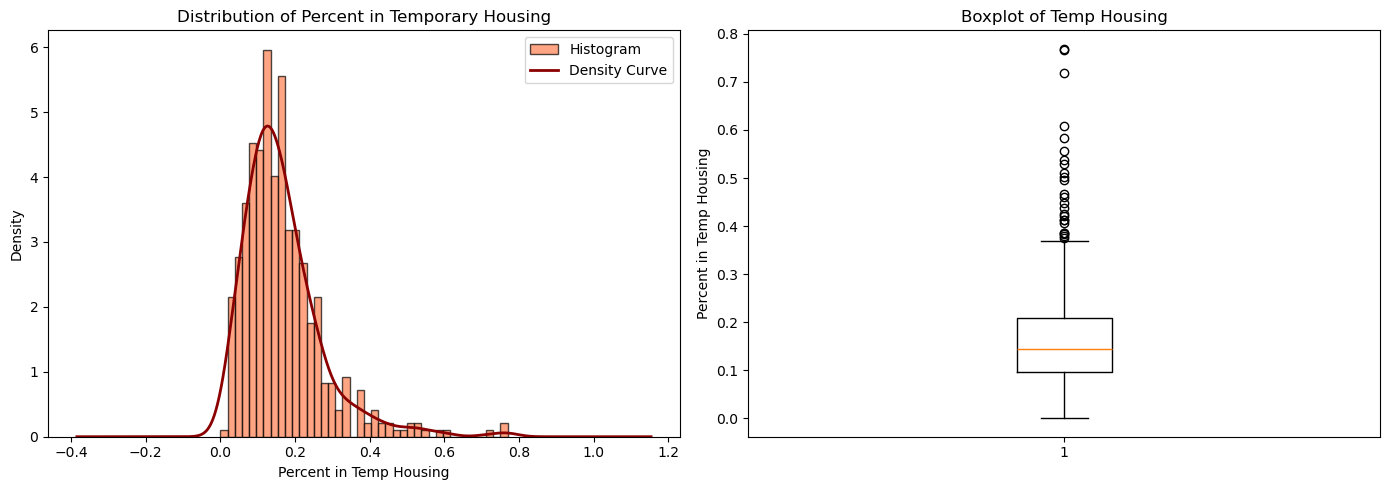

DISTRIBUTION STATISTICS FOR PERCENT TEMP HOUSING

--- Threshold Counts ---
Schools above 10% temp housing: 368 (72.7%)
Schools above 20% temp housing: 136 (26.9%)


In [11]:
temp_housing = dim_environment['percent_temp_housing'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(temp_housing, bins=40, density=True, alpha=0.7, color='coral', edgecolor='black', label='Histogram')
temp_housing.plot(kind='kde', ax=axes[0], color='darkred', linewidth=2, label='Density Curve')
axes[0].set_xlabel('Percent in Temp Housing')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Percent in Temporary Housing')
axes[0].legend()

axes[1].boxplot(temp_housing, vert=True)
axes[1].set_ylabel('Percent in Temp Housing')
axes[1].set_title('Boxplot of Temp Housing')

plt.tight_layout()
plt.show()


print('=' * 55)
print('DISTRIBUTION STATISTICS FOR PERCENT TEMP HOUSING')
print('=' * 55)

above_10 = (temp_housing > 0.10).sum()
above_20 = (temp_housing > 0.20).sum()
total = len(temp_housing)

print(f'\n--- Threshold Counts ---')
print(f'Schools above 10% temp housing: {above_10} ({above_10/total*100:.1f}%)')
print(f'Schools above 20% temp housing: {above_20} ({above_20/total*100:.1f}%)')

# Temporary housing and ENI interaction

CORRELATION MATRIX: TEMP HOUSING vs ENI
                      percent_temp_housing  economic_need_index
percent_temp_housing              1.000000             0.689292
economic_need_index               0.689292             1.000000


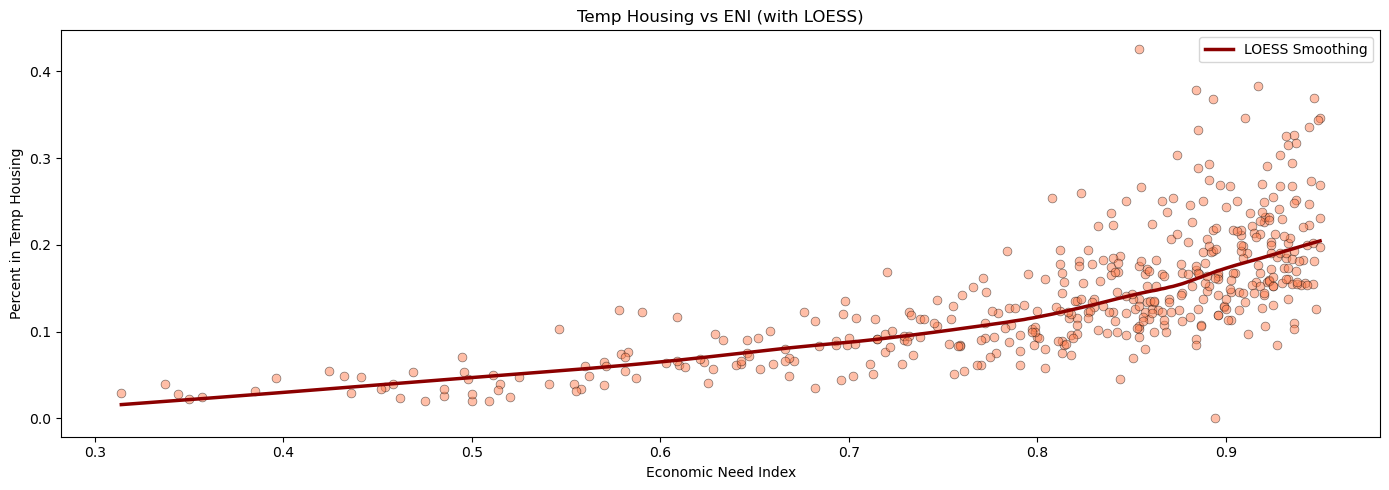


Pearson Correlation:  0.6893
Spearman Correlation: 0.7736

INTERPRETATION
• Moderate positive correlation — temp housing is related to ENI but carries independent information


In [18]:

housing_eni = dim_environment[['percent_temp_housing', 'economic_need_index']].dropna()

corr_matrix = housing_eni.corr()
print('=' * 50)
print('CORRELATION MATRIX: TEMP HOUSING vs ENI')
print('=' * 50)
print(corr_matrix.to_string())

fig, ax = plt.subplots(figsize=(14, 5))
ax.scatter(housing_eni['economic_need_index'], housing_eni['percent_temp_housing'],
                alpha=0.5, c='coral', edgecolors='black', linewidth=0.5, s=40)

from statsmodels.nonparametric.smoothers_lowess import lowess
smoothed = lowess(housing_eni['percent_temp_housing'], housing_eni['economic_need_index'], frac=0.4)
ax.plot(smoothed[:, 0], smoothed[:, 1], color='darkred', linewidth=2.5, label='LOESS Smoothing')

ax.set_xlabel('Economic Need Index')
ax.set_ylabel('Percent in Temp Housing')
ax.set_title('Temp Housing vs ENI (with LOESS)')
ax.legend()

plt.tight_layout()
plt.show()

pearson_r = housing_eni['percent_temp_housing'].corr(housing_eni['economic_need_index'])
spearman_r = housing_eni['percent_temp_housing'].corr(housing_eni['economic_need_index'], method='spearman')

print(f'\nPearson Correlation:  {pearson_r:.4f}')
print(f'Spearman Correlation: {spearman_r:.4f}')

print('\n' + '=' * 50)
print('INTERPRETATION')
print('=' * 50)
if pearson_r > 0.7:
    print('• Strong positive correlation — temp housing may largely be a proxy for ENI')
elif pearson_r > 0.4:
    print('• Moderate positive correlation — temp housing is related to ENI but carries independent information')
else:
    print('• Weak correlation — temp housing varies independently from ENI')
    print('• These are distinct dimensions of disadvantage')


### FAMILY INVOLVEMENT vs COLLEGE & CAREER READINESS
Does high family involvement predict high CCR? How does high economic need moderate that relationship?

In [20]:

fam_ccr = dim_environment[['family_involvement_pct_positive', 
                           'metric_value_4yr_ccr_all_students', 
                           'economic_need_index']].dropna()

# Overall correlations
print("OVERALL: FAMILY INVOLVEMENT vs CCR")
print(f"Pearson r:  {fam_ccr['family_involvement_pct_positive'].corr(fam_ccr['metric_value_4yr_ccr_all_students']):.4f}")
print(f"Spearman r: {fam_ccr['family_involvement_pct_positive'].corr(fam_ccr['metric_value_4yr_ccr_all_students'], method='spearman'):.4f}")

# Stratify by ENI median
eni_median = fam_ccr['economic_need_index'].median()
fam_ccr['eni_group'] = pd.cut(fam_ccr['economic_need_index'], bins=[0, eni_median, 1], labels=['Lower ENI', 'Higher ENI'])

print("\nSTRATIFIED BY ENI:")
for group, df in fam_ccr.groupby('eni_group'):
    r = df['family_involvement_pct_positive'].corr(df['metric_value_4yr_ccr_all_students'])
    print(f"{group}: mean CCR = {df['metric_value_4yr_ccr_all_students'].mean():.1f}, Pearson r = {r:.4f}")

OVERALL: FAMILY INVOLVEMENT vs CCR
Pearson r:  -0.1237
Spearman r: -0.1151

STRATIFIED BY ENI:
Lower ENI: mean CCR = 65.3, Pearson r = -0.1575
Higher ENI: mean CCR = 45.4, Pearson r = -0.0088


### Why CCR is very important, Proving that post secondary outcome is directly tie to ccr

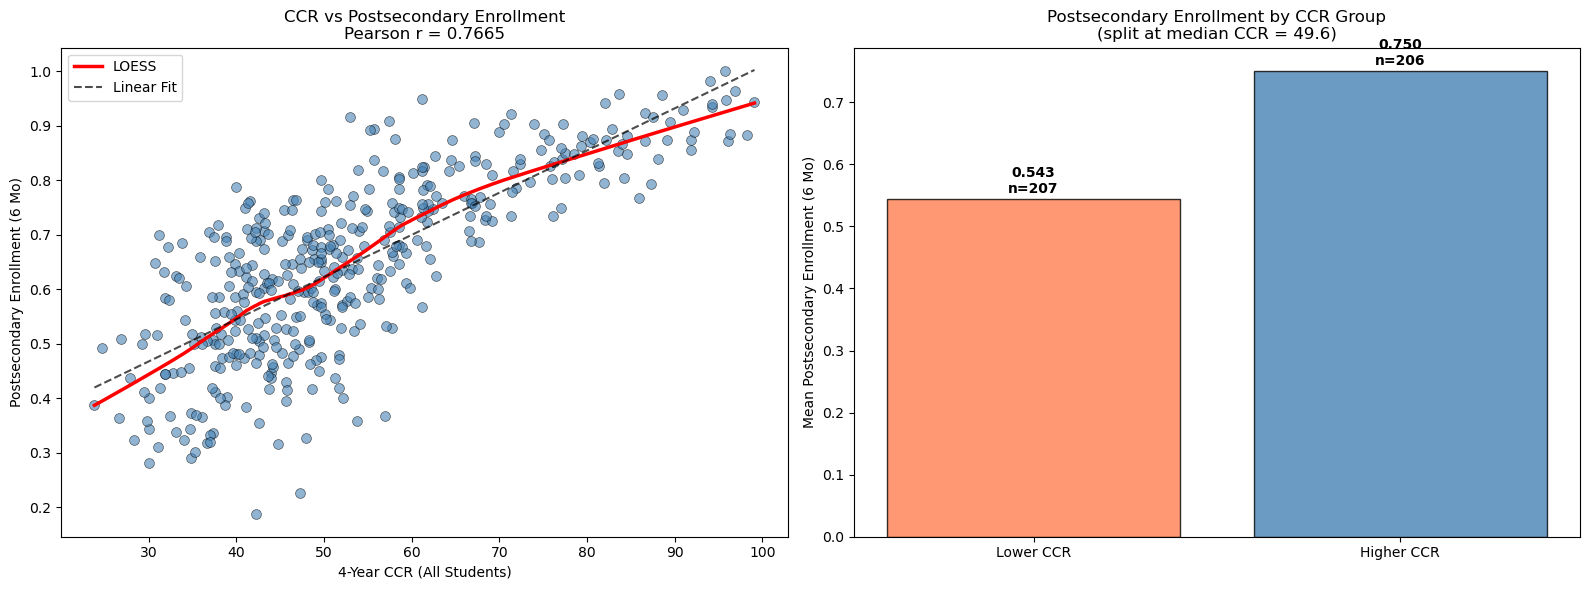

CORRELATION: CCR vs POSTSECONDARY ENROLLMENT

Pearson Correlation:  0.7665


In [27]:

ccr_post = dim_environment[['metric_value_4yr_ccr_all_students', 'metric_value_postsecondary_enrollment_6_months']].dropna()

pearson_r = ccr_post['metric_value_4yr_ccr_all_students'].corr(ccr_post['metric_value_postsecondary_enrollment_6_months'])
spearman_r = ccr_post['metric_value_4yr_ccr_all_students'].corr(ccr_post['metric_value_postsecondary_enrollment_6_months'], method='spearman')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(ccr_post['metric_value_4yr_ccr_all_students'], ccr_post['metric_value_postsecondary_enrollment_6_months'],
                alpha=0.6, c='steelblue', edgecolors='black', linewidth=0.5, s=50)

smoothed = lowess(ccr_post['metric_value_postsecondary_enrollment_6_months'], ccr_post['metric_value_4yr_ccr_all_students'], frac=0.4)
axes[0].plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2.5, label='LOESS')

z = np.polyfit(ccr_post['metric_value_4yr_ccr_all_students'], ccr_post['metric_value_postsecondary_enrollment_6_months'], 1)
p = np.poly1d(z)
x_line = np.linspace(ccr_post['metric_value_4yr_ccr_all_students'].min(), ccr_post['metric_value_4yr_ccr_all_students'].max(), 100)
axes[0].plot(x_line, p(x_line), 'k--', linewidth=1.5, alpha=0.7, label='Linear Fit')

axes[0].set_xlabel('4-Year CCR (All Students)')
axes[0].set_ylabel('Postsecondary Enrollment (6 Mo)')
axes[0].set_title(f'CCR vs Postsecondary Enrollment\nPearson r = {pearson_r:.4f}')
axes[0].legend()

ccr_median = ccr_post['metric_value_4yr_ccr_all_students'].median()
ccr_post['ccr_group'] = pd.cut(ccr_post['metric_value_4yr_ccr_all_students'],
                                bins=[ccr_post['metric_value_4yr_ccr_all_students'].min() - 0.01, ccr_median, ccr_post['metric_value_4yr_ccr_all_students'].max() + 0.01],
                                labels=['Lower CCR', 'Higher CCR'])

colors_bar = ['coral', 'steelblue']
axes[1].bar(group_means.index, group_means['mean'], color=colors_bar, edgecolor='black', alpha=0.8)
axes[1].set_ylabel('Mean Postsecondary Enrollment (6 Mo)')
axes[1].set_title(f'Postsecondary Enrollment by CCR Group\n(split at median CCR = {ccr_median:.1f})')
for i, (idx, row) in enumerate(group_means.iterrows()):
    axes[1].text(i, row['mean'] + 0.01, f"{row['mean']:.3f}\nn={int(row['count'])}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print('=' * 60)
print('CORRELATION: CCR vs POSTSECONDARY ENROLLMENT')
print('=' * 60)
print(f'\nPearson Correlation:  {pearson_r:.4f}')



### Hypothesis testing: Graduation is less sensitive to structural disadvantage than CCR

In [35]:
# Prepare data
hyp_df = dim_environment[['economic_need_index', 
                          'metric_value_4yr_graduation_rate_all_students', 
                          'metric_value_4yr_ccr_all_students']].dropna()

X = sm.add_constant(hyp_df['economic_need_index'])

# OLS regressions
model_grad = sm.OLS(hyp_df['metric_value_4yr_graduation_rate_all_students'], X).fit()
model_ccr = sm.OLS(hyp_df['metric_value_4yr_ccr_all_students'], X).fit()

# Slopes and SEs
slope_grad = model_grad.params['economic_need_index']
slope_ccr = model_ccr.params['economic_need_index']
se_grad = model_grad.bse['economic_need_index']
se_ccr = model_ccr.bse['economic_need_index']

# Residual correlation and slope difference test
resid_corr = np.corrcoef(model_grad.resid, model_ccr.resid)[0, 1]
se_diff = np.sqrt(se_grad**2 + se_ccr**2 - 2 * resid_corr * se_grad * se_ccr)
t_stat = (slope_grad - slope_ccr) / se_diff
df_test = len(hyp_df) - 2

p_value_one_tail = 1 - stats.t.cdf(t_stat, df=df_test)

# Print minimal summary
print("OLS Slope Comparison: ENI Effect")
print(f"Graduation Rate slope: {slope_grad:.4f} ± {1.96*se_grad:.4f}")
print(f"CCR slope:             {slope_ccr:.4f} ± {1.96*se_ccr:.4f}")
print(f"Slope difference:      {slope_grad - slope_ccr:.4f} ± {se_diff:.4f}")
print(f"t-statistic:           {t_stat:.4f}, one-tailed p = {p_value_one_tail:.4e}")

# Conclusion
if p_value_one_tail < 0.05:
    print("→ CCR is significantly more sensitive to ENI than Graduation Rate")
else:
    print("→ No significant difference in ENI sensitivity between the two outcomes")

OLS Slope Comparison: ENI Effect
Graduation Rate slope: -0.2923 ± 0.0495
CCR slope:             -89.8947 ± 7.3933
Slope difference:      89.6024 ± 3.7590
t-statistic:           23.8367, one-tailed p = 0.0000e+00
→ CCR is significantly more sensitive to ENI than Graduation Rate


***

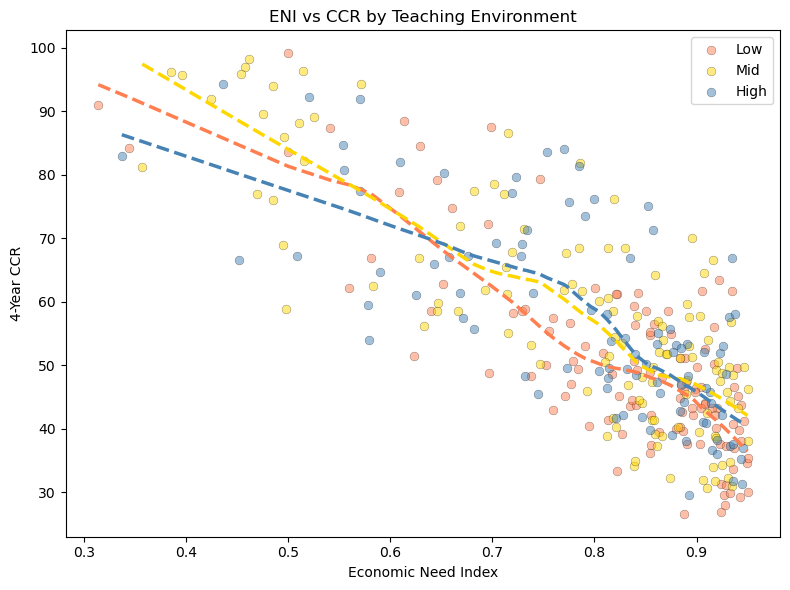

ENI → CCR slopes by teaching environment:
Low Teaching Env: slope = -93.9330 ± 13.5320
Mid Teaching Env: slope = -91.6695 ± 11.9973
High Teaching Env: slope = -82.6722 ± 16.4538

Interaction (ENI×Teaching) coefficient: 1.3079, p = 2.9514e-02
→ Teaching environment BUFFERS the negative effect of ENI on CCR


In [38]:
# MODERATION ANALYSIS: Does Teaching Environment reduce ENI's impact on CCR?
# H₀: Teaching environment does NOT moderate the ENI → CCR relationship
# H₁: Teaching environment BUFFERS the negative effect of ENI on CCR

import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess

# Prepare data
mod_df = dim_environment[['teaching_environment_pct_positive', 
                          'economic_need_index', 
                          'metric_value_4yr_ccr_all_students']].dropna()

# Standardize for interaction
mod_df['eni_z'] = (mod_df['economic_need_index'] - mod_df['economic_need_index'].mean()) / mod_df['economic_need_index'].std()
mod_df['teach_z'] = (mod_df['teaching_environment_pct_positive'] - mod_df['teaching_environment_pct_positive'].mean()) / mod_df['teaching_environment_pct_positive'].std()
mod_df['eni_x_teach'] = mod_df['eni_z'] * mod_df['teach_z']

# Interaction model
X3 = sm.add_constant(mod_df[['eni_z', 'teach_z', 'eni_x_teach']])
model3 = sm.OLS(mod_df['metric_value_4yr_ccr_all_students'], X3).fit()

# ENI slopes by teaching environment tercile
mod_df['teach_group'] = pd.qcut(mod_df['teaching_environment_pct_positive'], q=3,
                                 labels=['Low', 'Mid', 'High'])
group_slopes = []
colors_t = {'Low': 'coral', 'Mid': 'gold', 'High': 'steelblue'}

for g, df in mod_df.groupby('teach_group'):
    X_g = sm.add_constant(df['economic_need_index'])
    m = sm.OLS(df['metric_value_4yr_ccr_all_students'], X_g).fit()
    group_slopes.append({'Group': g, 'ENI Slope': m.params['economic_need_index'], 'SE': m.bse['economic_need_index']})
slope_df = pd.DataFrame(group_slopes).set_index('Group')

# ── Plot: ENI vs CCR stratified by teaching environment ──
fig, ax = plt.subplots(figsize=(8, 6))
for g, df in mod_df.groupby('teach_group'):
    ax.scatter(df['economic_need_index'], df['metric_value_4yr_ccr_all_students'],
               alpha=0.5, c=colors_t[g], edgecolors='black', linewidth=0.3, s=40, label=g)
    sm_line = lowess(df['metric_value_4yr_ccr_all_students'], df['economic_need_index'], frac=0.5)
    ax.plot(sm_line[:, 0], sm_line[:, 1], color=colors_t[g], linewidth=2.5, linestyle='--')
ax.set_xlabel('Economic Need Index')
ax.set_ylabel('4-Year CCR')
ax.set_title('ENI vs CCR by Teaching Environment')
ax.legend()
plt.tight_layout()
plt.show()

# ──summary ──
print("ENI → CCR slopes by teaching environment:")
for g in slope_df.index:
    slope = slope_df.loc[g, 'ENI Slope']
    se = slope_df.loc[g, 'SE']
    print(f"{g} Teaching Env: slope = {slope:.4f} ± {1.96*se:.4f}")

interaction_coef = model3.params['eni_x_teach']
interaction_p = model3.pvalues['eni_x_teach']
print(f"\nInteraction (ENI×Teaching) coefficient: {interaction_coef:.4f}, p = {interaction_p:.4e}")

if interaction_p < 0.05:
    print("→ Teaching environment BUFFERS the negative effect of ENI on CCR")
else:
    print("→ No significant moderation by teaching environment")

***